<a href="https://colab.research.google.com/github/AVerma27/U-Net-Models/blob/main/DC_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining Functions

In [ ]:

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import tensorflow as tf
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pylab as plt

from tensorflow import reduce_sum
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

In [ ]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Data Preparation

Performing Data Augmentation

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'/content/drive/MyDrive/membrane - DCUNet/train','image','label',data_gen_args,save_to_dir = "/content/drive/MyDrive/membrane - DCUNet/train/aug")

In [ ]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


# Model

## DCUNet

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def DCBlock(U, inp, alpha = 1.67):
    W = alpha * U

    #shortcut = inp

    #shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
    #                      int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3_1 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5_1 = conv2d_bn(conv3x3_1, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7_1 = conv2d_bn(conv5x5_1, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1], axis=3)
    out1 = BatchNormalization(axis=3)(out1)
    
    conv3x3_2 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5_2 = conv2d_bn(conv3x3_2, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7_2 = conv2d_bn(conv5x5_2, int(W*0.5), 3, 3,
                        activation='relu', padding='same')
    out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2], axis=3)
    out2 = BatchNormalization(axis=3)(out2)

    out = add([out1, out2])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

def ResPath(filters, length, inp):
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

def DCUNet(pretrained_weights = None,input_size = (256,256,1)):

    inputs = Input(input_size)

    dcblock1 = DCBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(dcblock1)
    dcblock1 = ResPath(32, 4, dcblock1)

    dcblock2 = DCBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(dcblock2)
    dcblock2 = ResPath(32*2, 3, dcblock2)

    dcblock3 = DCBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(dcblock3)
    dcblock3 = ResPath(32*4, 2, dcblock3)

    dcblock4 = DCBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(dcblock4)
    dcblock4 = ResPath(32*8, 1, dcblock4)

    dcblock5 = DCBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(dcblock5), dcblock4], axis=3)
    dcblock6 = DCBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(dcblock6), dcblock3], axis=3)
    dcblock7 = DCBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(dcblock7), dcblock2], axis=3)
    dcblock8 = DCBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(dcblock8), dcblock1], axis=3)
    dcblock9 = DCBlock(32, up9)

    conv10 = conv2d_bn(dcblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

#### Main

In [ ]:
 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,"/content/drive/MyDrive/membrane - DCUNet/train",'image','label',data_gen_args,save_to_dir = None)

model = DCUNet()
model_checkpoint = ModelCheckpoint('DCUNet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  72          ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 8)  72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  24         ['conv2d[0][0]']             

#### Defining Losses

In [ ]:
from keras import backend as K 
'''
# different loss functions
def dice_coef(y_true, y_pred):
    smooth = 1.0  #0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred)

def iou_loss(y_true,y_pred):
    return 1 - jacard(y_true, y_pred)
    

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)


def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

'''

'\n# different loss functions\ndef dice_coef(y_true, y_pred):\n    smooth = 1.0  #0.0\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n\ndef jacard(y_true, y_pred):\n\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum ( y_true_f * y_pred_f)\n    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)\n\n    return intersection/union\n\ndef dice_coef_loss(y_true,y_pred):\n    return 1 - dice_coef(y_true,y_pred)\n\ndef iou_loss(y_true,y_pred):\n    return 1 - jacard(y_true, y_pred)\n    \n\ndef tversky(y_true, y_pred):\n    y_true_pos = K.flatten(y_true)\n    y_pred_pos = K.flatten(y_pred)\n    true_pos = K.sum(y_true_pos * y_pred_pos)\n    false_neg = K.sum(y_true_pos * (1-y_pred_pos))\n    false_pos = K.sum((1-y_true_pos)*y_pred_pos)\n    alpha = 0.75\n    smooth = 1\n    return (true_pos

In [ ]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
from tensorflow import reduce_sum
from tensorflow.keras.losses import binary_crossentropy

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


Jacard_coefficient from: https://github.com/bnsreenu/python_for_microscopists/blob/master/207-simple_unet_model_with_jacard.py

In [ ]:
from keras import backend as K 


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

#### Train DC-UNet

In [ ]:
model.compile(optimizer='adam',  loss = [jacard_coef_loss], metrics = [jacard_coef])

In [ ]:
epoch =100
history_jaccard = model.fit_generator(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])


Found 30 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Found 30 images belonging to 1 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: -0.5287 - jacard_coef: 0.5287
Epoch 1: loss improved from inf to -0.52867, saving model to DCUNet_membrane.hdf5
20/20 [==============================] - 28s 206ms/step - loss: -0.5287 - jacard_coef: 0.5287
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: -0.5639 - jacard_coef: 0.5639
Epoch 2: loss improved from -0.52867 to -0.56389, saving model to DCUNet_membrane.hdf5
20/20 [==============================] - 4s 206ms/step - loss: -0.5639 - jacard_coef: 0.5639
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: -0.5752 - jacard_coef: 0.5752
Epoch 3: loss improved from -0.56389 to -0.57523, saving model to DCUNet_membrane.hdf5
20/20 [==============================] - 4s 228ms/step - loss: -0.5752 - jacard_coef: 0.5752
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: -0.5814 - jacard_coef: 0.5814
Epoch 4: loss improved from 

In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss,'accuracy'])

In [ ]:
history_dice = model.fit(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])


Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.3887 - dice_loss: 0.1282 - accuracy: 0.9343
Epoch 1: loss did not improve from -0.77503
20/20 [==============================] - 11s 168ms/step - loss: 0.3887 - dice_loss: 0.1282 - accuracy: 0.9343
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.3883 - dice_loss: 0.1278 - accuracy: 0.9314
Epoch 2: loss did not improve from -0.77503
20/20 [==============================] - 3s 167ms/step - loss: 0.3883 - dice_loss: 0.1278 - accuracy: 0.9314
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.3850 - dice_loss: 0.1266 - accuracy: 0.9321
Epoch 3: loss did not improve from -0.77503
20/20 [==============================] - 3s 168ms/step - loss: 0.3850 - dice_loss: 0.1266 - accuracy: 0.9321
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.3862 - dice_loss: 0.1268 - accuracy: 0.9311
Epoch 4: loss did not improve from -0.77503
20/20 [=============================

In [ ]:

testGene = testGenerator("/content/drive/MyDrive/membrane - DCUNet/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("/content/drive/MyDrive/membrane/test",results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


30/30 [==============================] - 11s 263ms/step


In [ ]:
model.fit_generator(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


20/20 [==============================] - ETA: 0s - loss: 0.3625 - dice_loss: 0.1188 - accuracy: 0.9410
Epoch 1: loss did not improve from -0.77503
20/20 [==============================] - 3s 169ms/step - loss: 0.3625 - dice_loss: 0.1188 - accuracy: 0.9410
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.3703 - dice_loss: 0.1211 - accuracy: 0.9381
Epoch 2: loss did not improve from -0.77503
20/20 [==============================] - 3s 168ms/step - loss: 0.3703 - dice_loss: 0.1211 - accuracy: 0.9381
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.3615 - dice_loss: 0.1184 - accuracy: 0.9413
Epoch 3: loss did not improve from -0.77503
20/20 [==============================] - 3s 169ms/step - loss: 0.3615 - dice_loss: 0.1184 - accuracy: 0.9413
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.3681 - dice_loss: 0.1204 - accuracy: 0.9379
Epoch 4: loss did not improve from -0.77503
20/20 [==============================] - 3s 170ms

## Losses

In [ ]:
'''# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
from tensorflow import reduce_sum
from tensorflow.keras.losses import binary_crossentropy

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss'''

'# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet\nfrom tensorflow import reduce_sum\nfrom tensorflow.keras.losses import binary_crossentropy\n\ndef dsc(y_true, y_pred):\n    smooth = 1.\n    y_true_f = Flatten()(y_true)\n    y_pred_f = Flatten()(y_pred)\n    intersection = reduce_sum(y_true_f * y_pred_f)\n    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)\n    return score\n\ndef dice_loss(y_true, y_pred):\n    loss = 1 - dsc(y_true, y_pred)\n    return loss\n\ndef bce_dice_loss(y_true, y_pred):\n    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)\n    return loss'

In [ ]:
'''
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,"/content/drive/MyDrive/membrane/train",'image','label',data_gen_args,save_to_dir = None)

modelnn = Nest_Net()
modelnn.summary()


adam = Adam(lr = 0.05, epsilon = 0.1)
modelnn.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss])


model_checkpoint = ModelCheckpoint('nest_net_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
modelnn.fit_generator(myGene,steps_per_epoch=30,epochs=1,callbacks=[model_checkpoint])

testGene = testGenerator("/content/drive/MyDrive/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
#saveResult("/content/drive/MyDrive/membrane/test",results)'''

'\n#os.environ["CUDA_VISIBLE_DEVICES"] = "0"\n\n\ndata_gen_args = dict(rotation_range=0.2,\n                    width_shift_range=0.05,\n                    height_shift_range=0.05,\n                    shear_range=0.05,\n                    zoom_range=0.05,\n                    horizontal_flip=True,\n                    fill_mode=\'nearest\')\nmyGene = trainGenerator(2,"/content/drive/MyDrive/membrane/train",\'image\',\'label\',data_gen_args,save_to_dir = None)\n\nmodelnn = Nest_Net()\nmodelnn.summary()\n\n\nadam = Adam(lr = 0.05, epsilon = 0.1)\nmodelnn.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss])\n\n\nmodel_checkpoint = ModelCheckpoint(\'nest_net_membrane.hdf5\', monitor=\'loss\',verbose=1, save_best_only=True)\nmodelnn.fit_generator(myGene,steps_per_epoch=30,epochs=1,callbacks=[model_checkpoint])\n\ntestGene = testGenerator("/content/drive/MyDrive/membrane/test")\nresults = model.predict_generator(testGene,30,verbose=1)\n#saveResult("/content/drive/MyDrive/membr

In [ ]:
testGene = testGenerator("/content/drive/MyDrive/membrane/test")
print(testGene)

<generator object testGenerator at 0x7f7dee40bd50>


In [ ]:
results = model.predict_generator(testGene,30,verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


30/30 [==============================] - 8s 276ms/step


In [ ]:
#model.fit_generator(myGene,steps_per_epoch=20,epochs=5,callbacks=[model_checkpoint])

In [ ]:
print(results)

[[[[0.90142936]
   [0.9075146 ]
   [0.90561825]
   ...
   [0.9042666 ]
   [0.90175796]
   [0.88767684]]

  [[0.90132236]
   [0.90387994]
   [0.9023833 ]
   ...
   [0.903818  ]
   [0.9012464 ]
   [0.8849307 ]]

  [[0.9032344 ]
   [0.90464455]
   [0.9036386 ]
   ...
   [0.9031565 ]
   [0.8860696 ]
   [0.8126805 ]]

  ...

  [[0.8991604 ]
   [0.902323  ]
   [0.90088135]
   ...
   [0.9058507 ]
   [0.9031259 ]
   [0.9059054 ]]

  [[0.8913739 ]
   [0.89871275]
   [0.9016522 ]
   ...
   [0.904329  ]
   [0.9037035 ]
   [0.90551776]]

  [[0.8623498 ]
   [0.8931746 ]
   [0.8978137 ]
   ...
   [0.9019772 ]
   [0.9026525 ]
   [0.900879  ]]]


 [[[0.8997155 ]
   [0.90700275]
   [0.90543795]
   ...
   [0.41946915]
   [0.41788834]
   [0.5643392 ]]

  [[0.9003645 ]
   [0.9038842 ]
   [0.9017985 ]
   ...
   [0.42327997]
   [0.52265286]
   [0.7528617 ]]

  [[0.9012798 ]
   [0.9027299 ]
   [0.9051924 ]
   ...
   [0.7968201 ]
   [0.88966805]
   [0.89732206]]

  ...

  [[0.9003276 ]
   [0.90257037]
   [0.9

In [ ]:
#history = model.fit_generator(myGene,steps_per_epoch=20,epochs=5,callbacks=[model_checkpoint])

## Plots

In [ ]:
import matplotlib.pylab as plt

Text(0.5, 0, 'epoch')

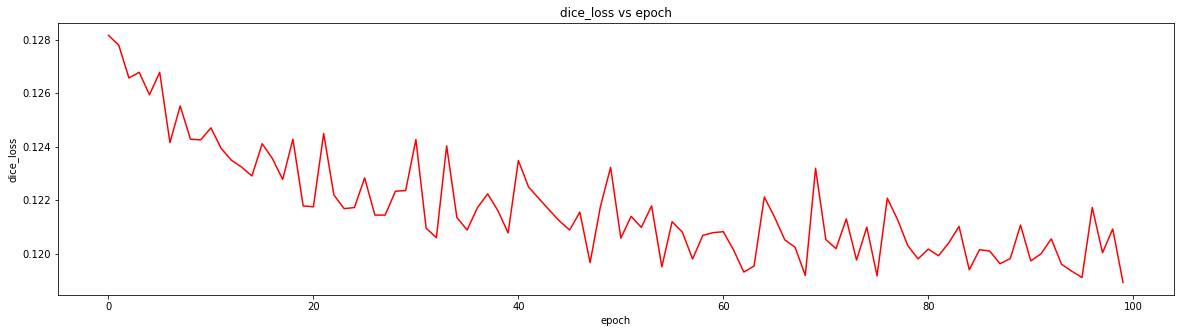

In [ ]:
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_dice.history['dice_loss'],color = 'Red')
plt.title('dice_loss vs epoch')
plt.ylabel('dice_loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

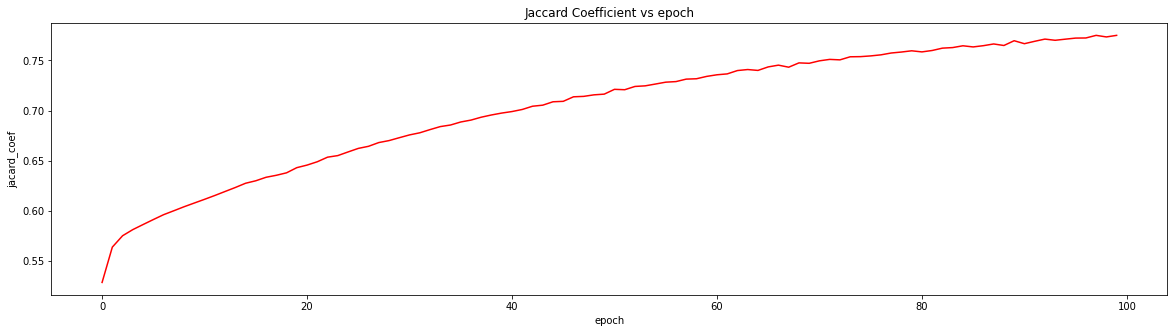

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_jaccard.history['jacard_coef'], color = 'Red')
plt.title('Jaccard Coefficient vs epoch')
plt.ylabel('jacard_coef')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

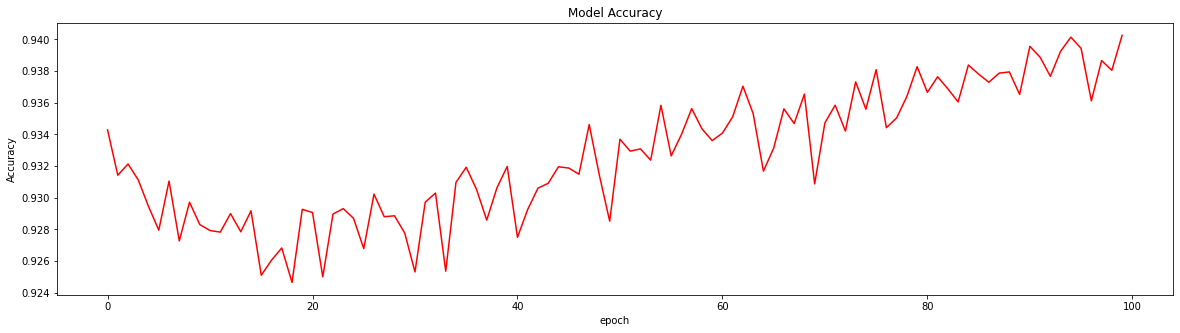

In [ ]:
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_dice.history['accuracy'], color = 'Red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')